In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import metrics

from ast import literal_eval

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_length = 24000
stocks = ['4549']
should_save_fig = True
kernels = ['linear', 'rbf', 'sigmoid']

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in kernels:
    d,  d_test = lob.load_prepared_data(stocks[0], length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d['prev_queue_imbalance'] = [None] + d['queue_imbalance'].iloc[0:len(d)-1].values.tolist()
    d.dropna(inplace=True)
    d_test['prev_queue_imbalance'] = [None] + d_test['queue_imbalance'].iloc[0:len(d_test)-1].values.tolist()
    d_test.dropna(inplace=True)
    d_stocks[s] = d
    d_test_stocks[s] = d_test

## SVM with queue imbalance

In [5]:
df_res = {}
for s in kernels:
    df_res_temp = pd.read_csv('../svm_queue_imbalance/res_svm/svm_linear_{}_len{}.csv'.format(
        stocks[0], data_length))
    df_res_temp = df_res_temp.append(
         pd.read_csv('../svm_queue_imbalance/res_svm/svm_sigmoid_{}_len{}.csv'.format(
             stocks[0], data_length)))
    df_res_temp = df_res_temp.append(
        pd.read_csv('../svm_queue_imbalance/res_svm/svm_rbf_{}_len{}.csv'.format(
            stocks[0], data_length)))
    df_res[s] = df_res_temp
    df_res[s].index = list(range(len(df_res[s])))


In [8]:
df_best_svm = pd.DataFrame()

idx_max = df_res[s].sort_values(by='matthews', ascending=False).groupby(
    'kernel')['matthews'].idxmax()
df_best_svm = df_best_svm.append(df_res[s].loc[idx_max])
df_best_svm

,Unnamed: 0,C,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
1,1,0.010,NaN,0.438775,que,NaN,0.109002,linear,0.121197,0.345167,...,0.119791,0.347924,0.577575,0.565851,0.435352,0.109229,0.119772,0.345953,0.587514,0.565871
232,9,0.010,NaN,0.440988,que,0.1,0.110685,rbf,0.124306,0.346020,...,0.119259,0.347967,0.574540,0.565546,0.436963,0.108809,0.120391,0.345596,0.596876,0.565901
41,34,0.001,10.0,0.444472,que,100.0,0.111446,sigmoid,0.126050,0.345721,...,-0.023102,0.282660,0.554722,0.487429,0.437130,0.105751,0.119926,0.343775,0.611828,0.564972


In [9]:
 from sklearn import utils

def get_classes_weights(y_train):
    classes = np.unique(y_train)
    class_weight_list = utils.class_weight.compute_class_weight('balanced', classes, y_train)
    class_weights = {classes[0]: class_weight_list[0], classes[1]: class_weight_list[1]}
    return class_weights

def fit_best_svm_classifier(df_best_svm, df, kernel=None):    
    gamma = df_best_svm[df_best_svm['kernel'] == kernel]['gamma'].values[0]
    coef0 = df_best_svm[df_best_svm['kernel'] == kernel]['coef0'].values[0]
    c = df_best_svm[df_best_svm['kernel'] == kernel]['C'].values[0]

    X = df['queue_imbalance'].values.reshape(-1, 1)
    y = df['mid_price_indicator']
   
    weights = get_classes_weights(y)
    clf = SVC(gamma=gamma, C=c, coef0=coef0, kernel=kernel, random_state=23131, class_weight=weights)
    clf.fit(X, y)
    return clf
    

In [10]:
def get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = log_clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
            df[f'pred'] = pred
            scores['{}_{}'.format(df_name, func_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'roc_auc': metrics.roc_auc_score,
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score, 
                   'matthews': metrics.matthews_corrcoef, 'kappa': metrics.cohen_kappa_score}
scores = []

for kernel in df_best_svm['kernel'].unique():
    stock = stocks[0]
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[kernel], kernel=kernel)
    dfs = {'train': d_stocks[kernel], 'test': d_test_stocks[kernel], }
    res_validation = model.validate_model(
        log_clf, 
        d_stocks[kernel][['queue_imbalance']], d_stocks[kernel]['mid_price_indicator'])
    res = get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock)
    res = {**res, **res_validation}
    scores.append(res)
df_scores = pd.DataFrame(scores)

In [11]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean(row[column]))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

for col in scores_columns:
    df_scores[col] = convert_scores(df_scores, col)
df_scores

,f1,kappa,matthews,precision,recall,roc_auc,stock,test_f1_score,test_kappa,test_matthews,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
0,0.438775,0.109002,0.121197,0.345167,0.603560,0.566472,4549,0.431925,0.122033,0.132665,...,0.119791,0.347924,0.577575,0.565851,"[0.429063670411985, 0.42677328594698655, 0.432...","[0.10642905309813722, 0.09953619060962282, 0.1...","[0.11459351114604649, 0.1079855783222802, 0.12...","[0.34689922480620156, 0.34228028503562946, 0.3...","[0.5622300745975658, 0.5666535587888321, 0.580...","[0.5629214471401556, 0.5593701310605436, 0.570..."
1,0.440988,0.110685,0.124306,0.346020,0.614044,0.567872,4549,0.431774,0.122431,0.132924,...,0.119259,0.347967,0.574540,0.565546,"[0.4321115892565663, 0.4303723248314278, 0.426...","[0.10824648945870152, 0.10205806537659579, 0.1...","[0.11719820879578352, 0.11141502471611715, 0.1...","[0.3473282442748092, 0.3430708109371348, 0.349...","[0.5716529250098155, 0.5772709398348408, 0.547...","[0.5643955787237488, 0.5612818626705747, 0.571..."
2,0.444472,0.111446,0.126050,0.345721,0.628882,0.568979,4549,0.369752,-0.010462,-0.012427,...,-0.023102,0.282660,0.554722,0.487429,"[0.4154952598888526, 0.41458299725762215, 0.44...","[0.1133391131902024, 0.10787921816098733, 0.10...","[0.11717896366058196, 0.1121591275914303, 0.12...","[0.35592271072528703, 0.3514770240700219, 0.33...","[0.49901845308205733, 0.5053086905230043, 0.66...","[0.5633648432454638, 0.5608879266267561, 0.570..."


In [13]:
print('Pivot values')
for i in range(len(kernels)):
    df = d_stocks[kernels[i]]
    print(np.mean([np.min(df[df['pred'] == 1]['queue_imbalance']), 
                  np.max(df[df['pred'] == 0]['queue_imbalance'])]))

Pivot values
0.017009479175546217
0.020533971669307507
-2.5748827817695386e-05


Saving


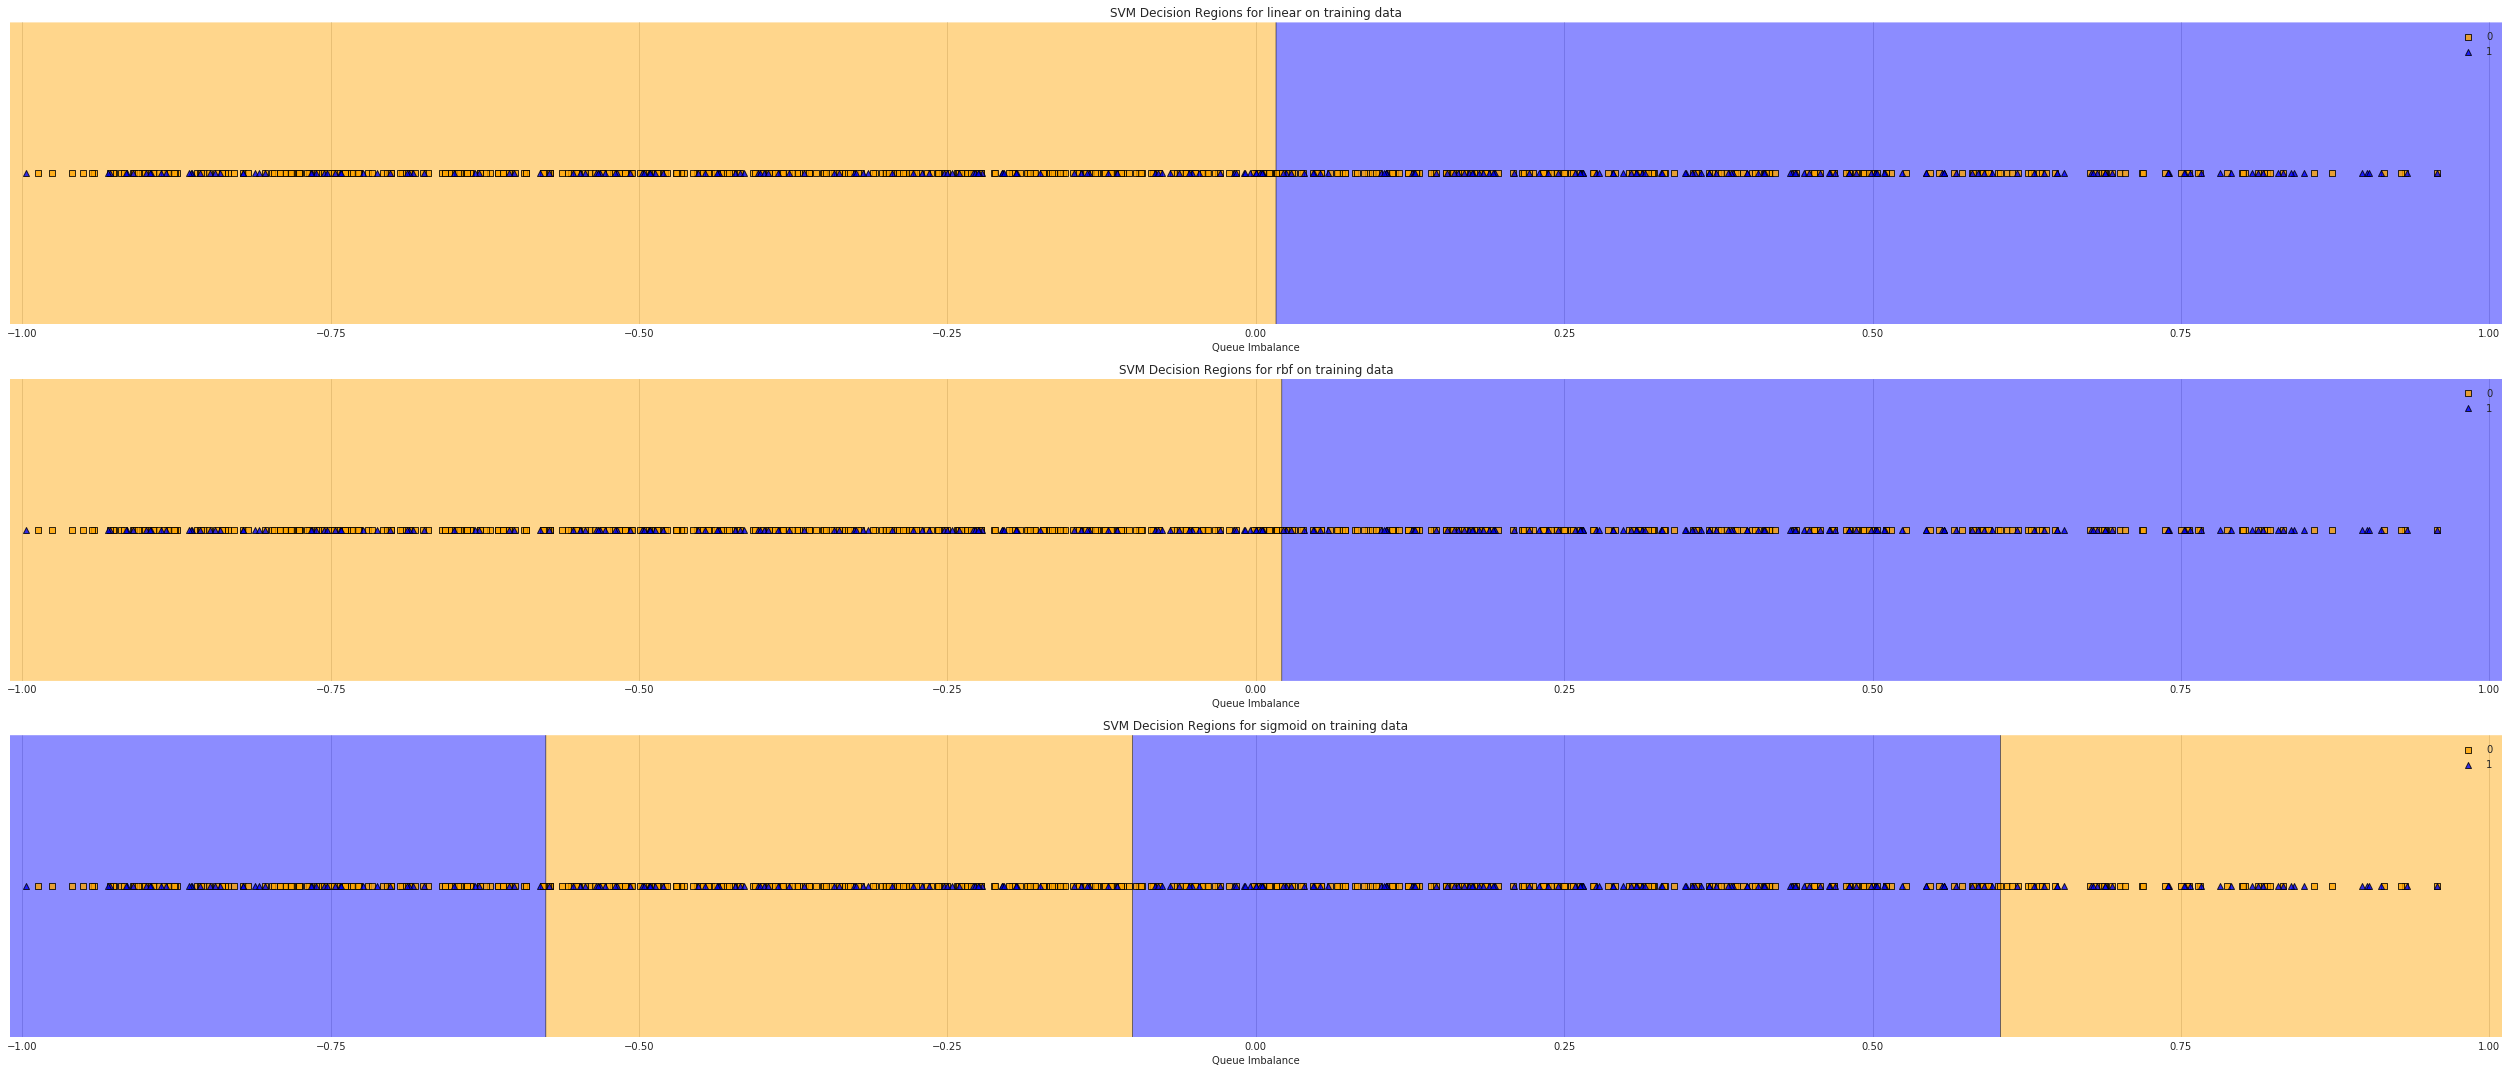

In [16]:
f, ax = plt.subplots(3, 1, figsize=(35, 15), sharex=True)
i = 0

for i in range(len(kernels)):
    s = kernels[i]
    df = d_stocks[s]
    X = d_stocks[s][['queue_imbalance']].values
    y = d_stocks[s]['mid_price_indicator'].values.astype(np.integer)

    clf = fit_best_svm_classifier(df_best_svm, d_stocks[s], kernel=s)
    plot_decision_regions(X[0:900], y[0:900], clf=clf,ax=ax[i], colors=','.join(['orange', 'blue']))
    ax[i].set_xlabel('Queue Imbalance')
    ax[i].set_title('SVM Decision Regions for {} on training data'.format(s))
    ax[i].set_xlim(-1.01, 1.01)
plt.tight_layout()
if should_save_fig:
    print('Saving')
    plt.savefig('svm_decision_region_4549.png')